# 뉴스 카테고리 다중분류 프로젝트


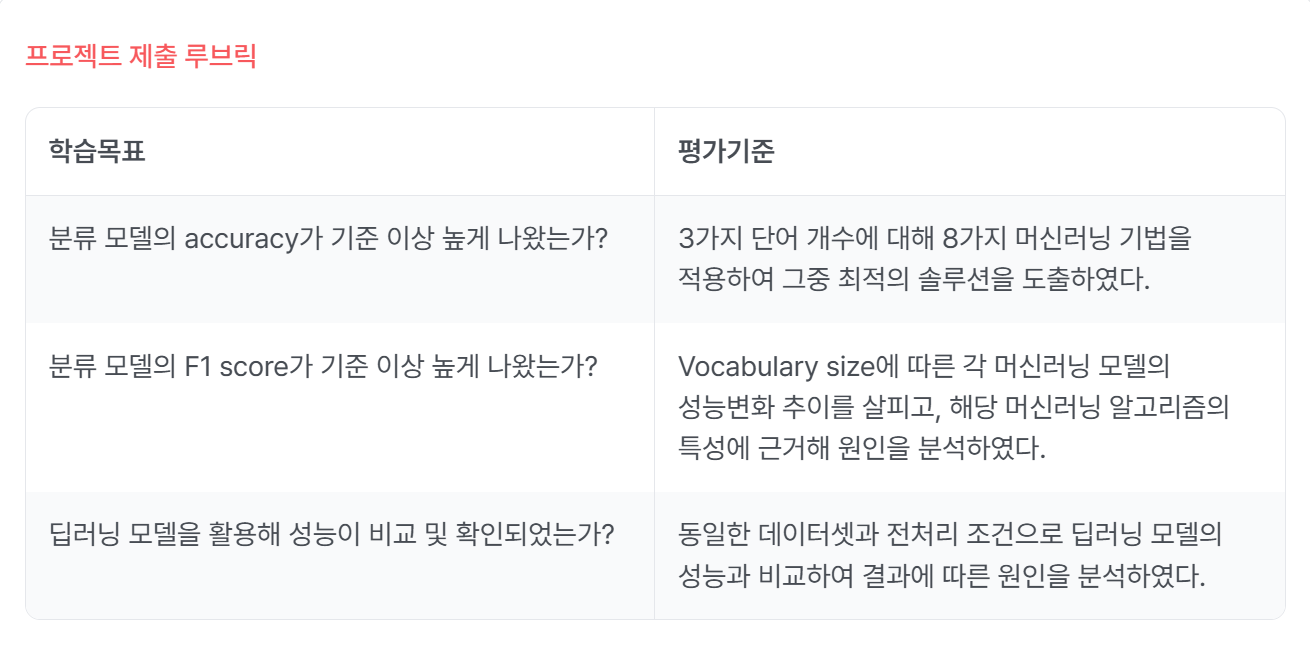

본인:  
- Multinominal Naive Bayes
- Support Vector Machine
- Gradient Boosting Classifier

나머지 팀원:  
- Logistic Regression
- Complement Naive Bayes Classifier(CNB)
- Decision Tree
- Random Forest
- Voting
- 1-D CNN  

위의 모델들로 vocab size에 따른 분류 성능을 비교한다.

# 1. 라이브러리 및 데이터 로드

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tensorflow.keras.datasets import reuters

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import json

In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(
    num_words=10000, # 많이 등장한 1만개의 단어만 사용하고 나머지는 unk으로 취급
    test_split=0.2
)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# 2. EDA

In [4]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [5]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


인덱스로 나온다  
-> 이미 전처리가 된 상태

In [6]:
print(y_train[0])
print(y_test[0])

3
3


In [7]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


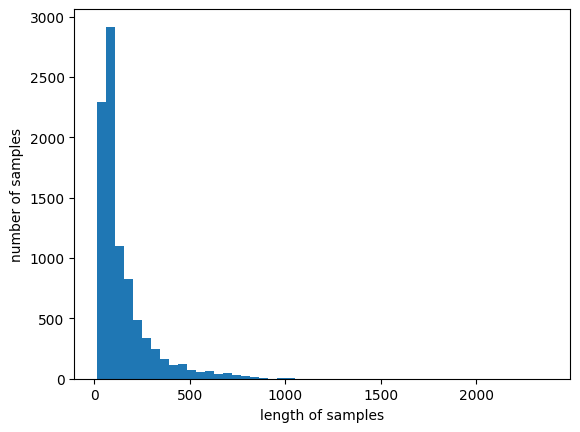

In [8]:
# 평균 길이 확인
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


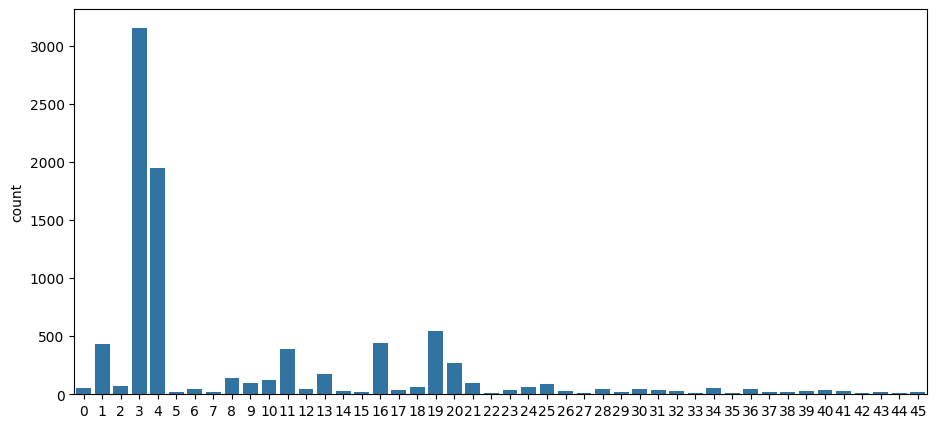

In [10]:
# 클래스의 분포 확인
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

## 데이터 복원

In [11]:
# word_index = reuters.get_word_index(path="reuters_word_index.json")
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/reuters_word_index.json

# 1. 파일 열기
with open('reuters_word_index.json', 'r', encoding='utf-8') as f:
    # 2. JSON 로드
    word_index = json.load(f)

print('=3')

--2025-11-14 07:04:14--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/reuters_word_index.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.207, 74.125.203.207, 74.125.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 550378 (537K) [application/json]
Saving to: ‘reuters_word_index.json’

reuters_word_index. 100%[===================>] 537.48K   925KB/s    in 0.6s    

2025-11-14 07:04:14 (925 KB/s) - ‘reuters_word_index.json’ saved [550378/550378]

=3


In [14]:
# word_index는 vocab이다.
word_index['the'] # 예시로 the는 1과 매핑됨

1

In [15]:
# 0, 1, 2는 pad, sos, unk 토큰이므로 이후의 토큰들에 대해 3을 더해줘야 한다.
index_to_word = { index+3 : word for word, index in word_index.items() }

In [17]:
print(index_to_word[4])

the


In [18]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [19]:
# 첫 행 복원
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [20]:
a = [4, 587, 23, 133, 6, 30, 515]
print(' '.join([index_to_word[index] for index in a]))

the transaction is expected to be completed


In [21]:
# 전체 train, test 데이터를 텍스트로 변환
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [22]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [23]:
x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for o

In [24]:
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the curren

# 4. 벡터화

In [27]:
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 9670)


In [28]:
# TF-IDF
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


# 5. 나이브 베이즈 분류기

In [30]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [31]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.6567230632235085


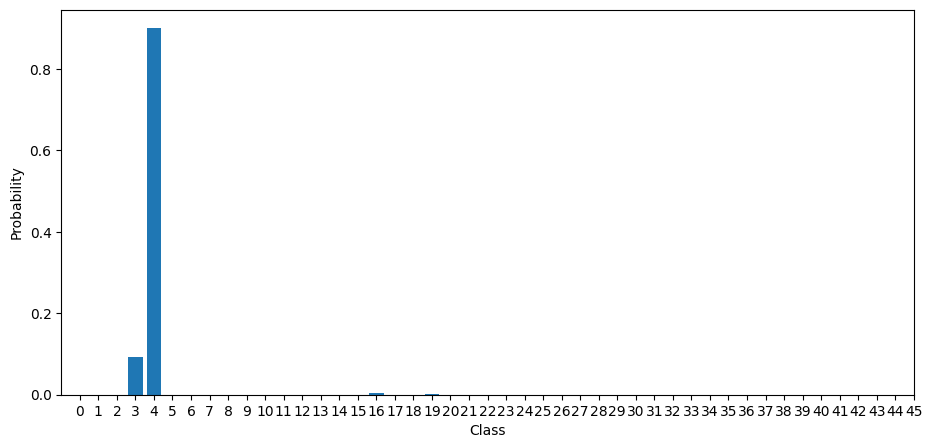

In [32]:
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

# 6. F1, confusion matrix


In [34]:
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

In [35]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(12,12))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

print('=3')

=3


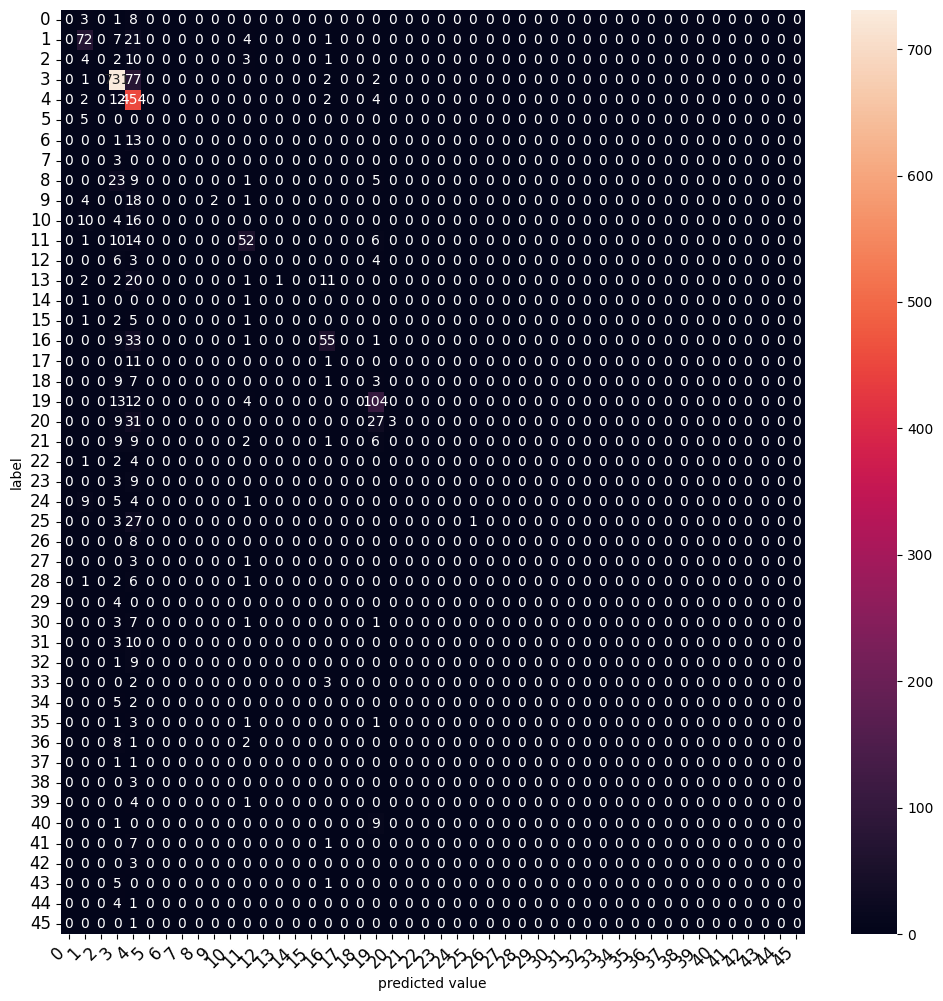

In [36]:
graph_confusion_matrix(model, tfidfv_test, y_test)

# 7. 다양한 ML 모델

## Complement Naive Bayes Classifier(CNB)
불균형 데이터를 고려해서 가중치를 부여한 나이브 베이즈 분류기

In [37]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [38]:
predicted = cb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7707034728406055


## 로지스틱 회귀

In [39]:
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [40]:
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.8085485307212823


## Linear SVM

In [41]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [42]:
predicted = lsvc.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7858414959928762


## 결정 트리

In [43]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [44]:
predicted = tree.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.6202137132680321


## 랜덤 포레스트

In [45]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [46]:
predicted = forest.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.674087266251113


## GradientBoostingClassifier
- 보통 RF 먼저 해보고 GBC 시도  
- 1~5 정도의 낮은 트리 사용
- 오래 걸림

In [54]:
grbt = GradientBoostingClassifier(random_state=0, verbose=3)
grbt.fit(tfidfv, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.4608           28.85m
         2       95544.1775           29.31m
         3      105411.1176           28.97m
         4 26490374809120023273815311180428975028469682405376.0000           28.75m
         5 3332464261431290140396159661966485664330965454944135799052730407441433455992203381429980979248826373623161338845118312409464832.0000           28.54m
         6 3332464261431290140396159661966485664330965454944135799052730407441433455992203381429980979248826373623161338845118312409464832.0000           28.22m
         7 3332464261431290140396159661966485664330965454944135799052730407441433455992203381429980979248826373623161338845118312409464832.0000           28.01m
         8 3332464261431290140396159661966485664330965454944135799052730407441433455992203381429980979248826373623161338845118312409464832.0000           27.68m
         9 33324642614312901403961596619664856643309654549441357990527304074414334559922033

GradientBoostingClassifier(random_state=0, verbose=3)

In [55]:
predicted = grbt.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7684772929652716


## Voting

In [56]:
# 20분 이상 소요될 수 있습니다.
# Voting을 구현해보세요. (Voing은 'soft'로 설정)
# 조건1 : 로지스틱회귀를 사용해주세요(패널티는 'L2'로 설정)
#조건 2: Complement Naive Bayes Classifier를 사용해주세요
#조건 3: GradientBoosting Classifier를 사용해주세요
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [57]:
predicted = voting_classifier.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.811219946571683
